# Libraries


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import os
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.25.2
pandas --> 2.0.3
cv2 --> 4.8.0
PIL --> 9.4.0
sklearn --> 1.2.2
torch --> 2.3.0+cu121
torchvision --> 0.18.0+cu121
tqdm --> 4.66.4
torchmetrics --> 1.4.0.post0


In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_properties("cuda:0"))

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# DataSet


## Dataset Property

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*   Loading and unzipping DataSet



In [ ]:
!unzip -q "/content/drive/MyDrive/AgeEstimater/Data/UTKFace_cropped.zip" -d '/content/'

In [ ]:
#pictures copy in the utkcropped folder twice in this version
shutil.rmtree('/content/utkcropped/utkcropped')

*   Some challenges in dataset: --(wrong label, wrong crop, special property)


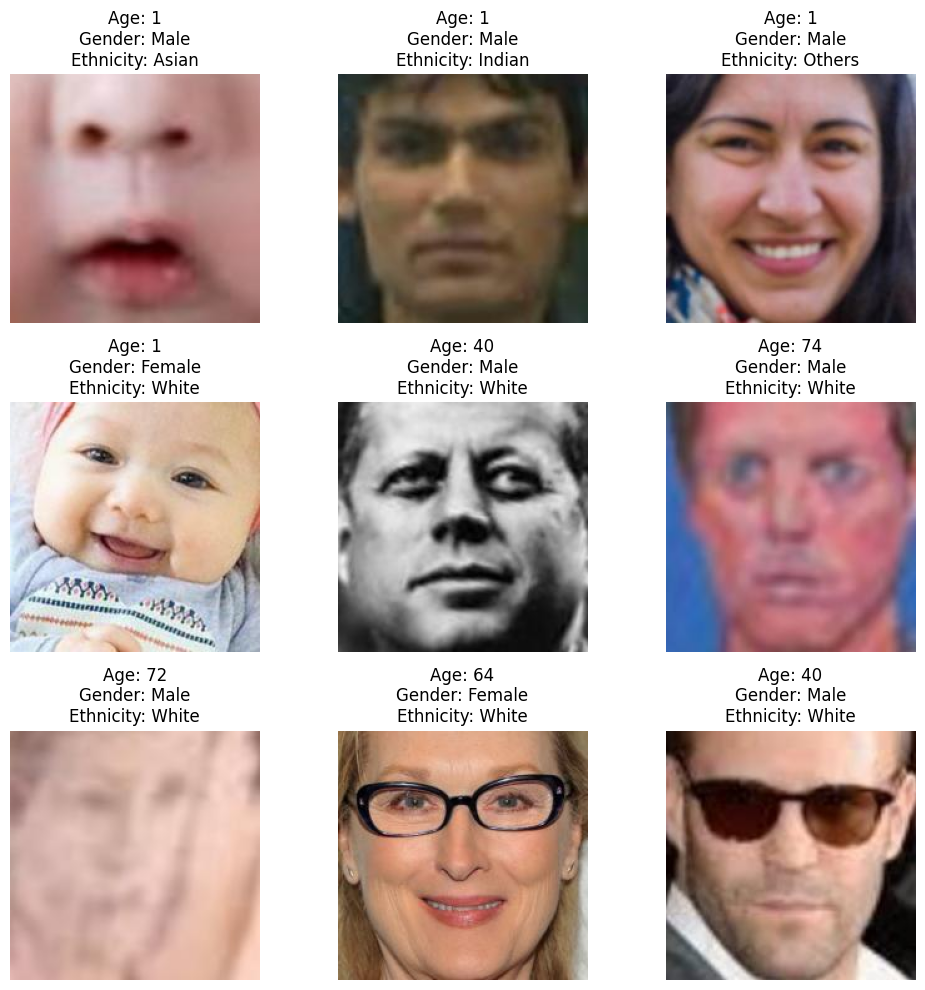

In [ ]:
dataset_folder = '/content/utkcropped'

def show_Pics(selected_image_files):

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display some interesting and challenging data
selected_pic_path = [
    "1_0_2_20161219205107772.jpg.chip.jpg",
    "1_0_3_20170104230640081.jpg.chip.jpg",
    "1_0_4_20161221193041157.jpg.chip.jpg",
    "1_1_0_20170109190937434.jpg.chip.jpg",
    "40_0_0_20170117185234626.jpg.chip.jpg",
    "74_0_0_20170111221942118.jpg.chip.jpg",
    "72_0_0_20170111222516126.jpg.chip.jpg",
    "64_1_0_20170110160643892.jpg.chip.jpg",
    "40_0_0_20170117185304858.jpg.chip.jpg"
]
show_Pics(selected_pic_path)

*   Creating CSV dataset

In [ ]:
dataset_folder = '/content/utkcropped'

#Initializing list for store
Image_name = []
Age = []
Gender = []
Ethnicity = []


#iterating over all samples and save younger_than_80_yo's labels in csv
for file_name in os.listdir(dataset_folder):
  if file_name.endswith(".jpg"):
    NamePart = file_name.split("_")
    if len(NamePart) < 4:
      print(file_name)
      continue

    SubjectAge = int(NamePart[0])

    if SubjectAge < 80:
      Image_name.append(file_name)
      Age.append(SubjectAge)
      Gender.append(["Male","Female"][int(NamePart[1])])
      Ethnicity.append(["White","Black","Asian","Indian","Others"][int(NamePart[2])])

data_dic = {
    "image_name": Image_name,
    "age": Age,
    "ethnicity": Ethnicity,
    "gender": Gender
}

data_df = pd.DataFrame(data_dic)
data_df.to_csv("/content/utkface_dataset.csv")

61_1_20170109150557335.jpg.chip.jpg
61_3_20170109150557335.jpg.chip.jpg
39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg


*  Analyse data distribution (singular and against other features)

count    23032.000000
mean        31.747178
std         17.910571
min          1.000000
25%         23.000000
50%         29.000000
75%         42.000000
max         79.000000
Name: age, dtype: float64


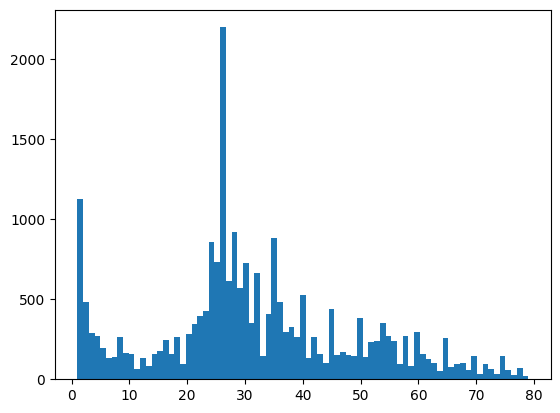

In [ ]:
# age distribution
print(data_df.age.describe())
plt.hist(data_df.age, bins = len(data_df.age.unique()));

gender
Male      12129
Female    10903
Name: count, dtype: int64


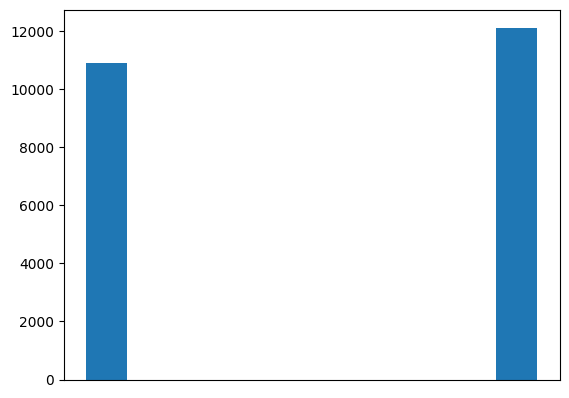

In [ ]:
#gender distribution
print(data_df.gender.value_counts())
plt.hist(data_df.gender, bins = 2, rwidth = 0.1);

ethnicity
White     9595
Black     4468
Indian    3949
Asian     3332
Others    1688
Name: count, dtype: int64


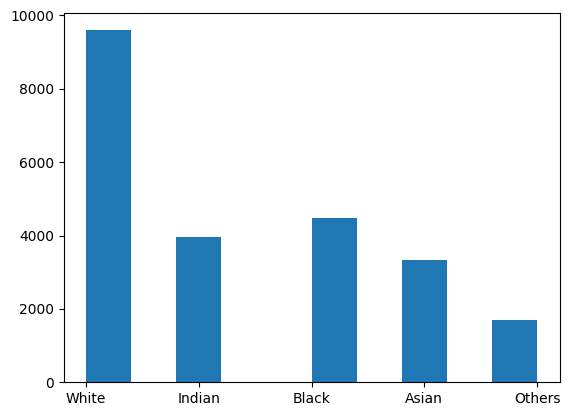

In [ ]:
#ethnicity distribution
print(data_df.ethnicity.value_counts())
plt.hist(data_df.ethnicity);

In [ ]:
pd.crosstab(data_df.gender,data_df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1808,2178,1696,929,4292
Male,1524,2290,2253,759,5303


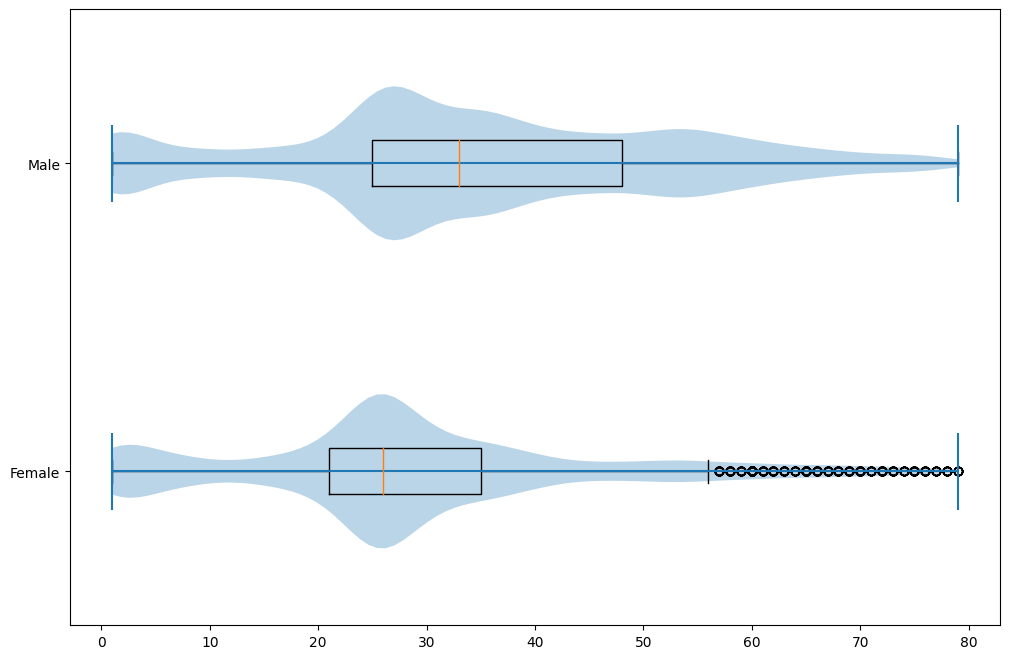

In [ ]:
plt.figure(figsize= (12,8))
plt.boxplot([data_df.age[data_df.gender == gen] for gen in data_df.gender.unique()],vert=False, labels = data_df.gender.unique());
plt.violinplot([data_df.age[data_df.gender == gen] for gen in data_df.gender.unique()],vert=False);

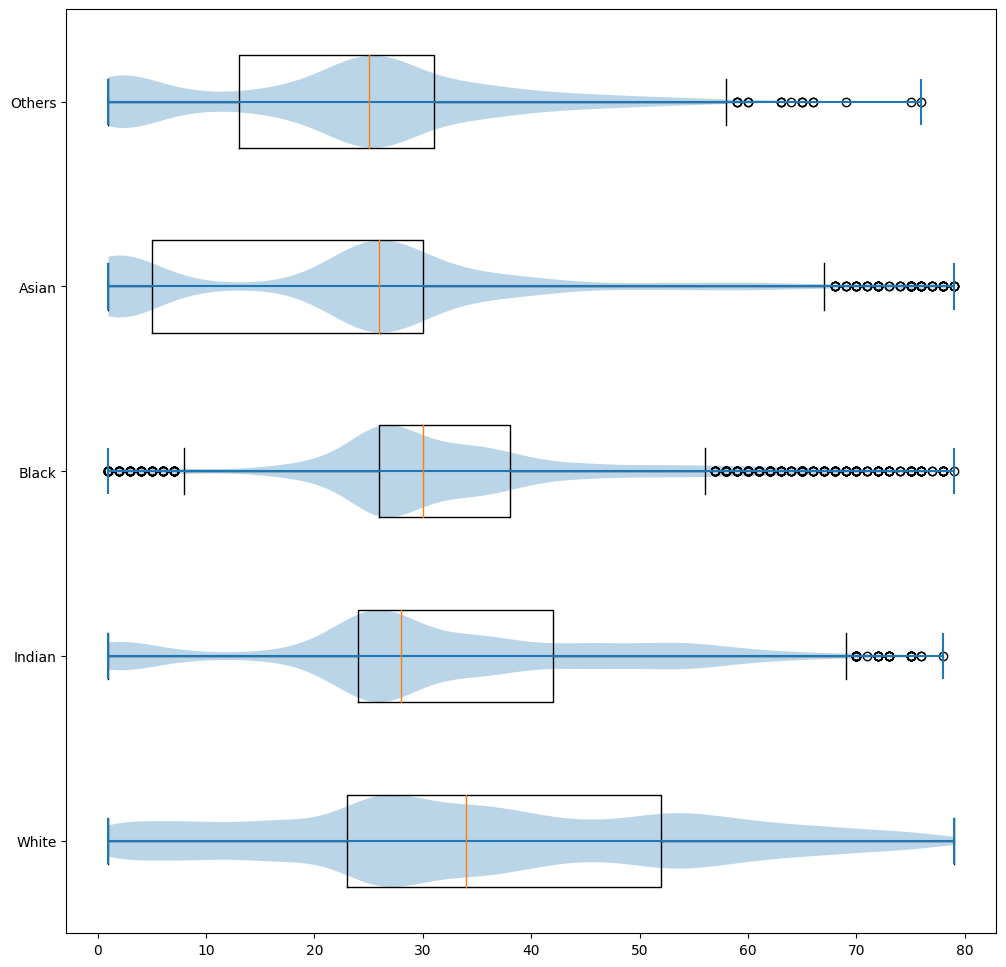

In [ ]:
plt.figure(figsize= (12,12))
plt.boxplot([data_df.age[data_df.ethnicity == ethn] for ethn in data_df.ethnicity.unique()],vert=False, labels = data_df.ethnicity.unique());
plt.violinplot([data_df.age[data_df.ethnicity == ethn] for ethn in data_df.ethnicity.unique()],vert=False);

## Dataset Preparation

All CSV files created successfully.


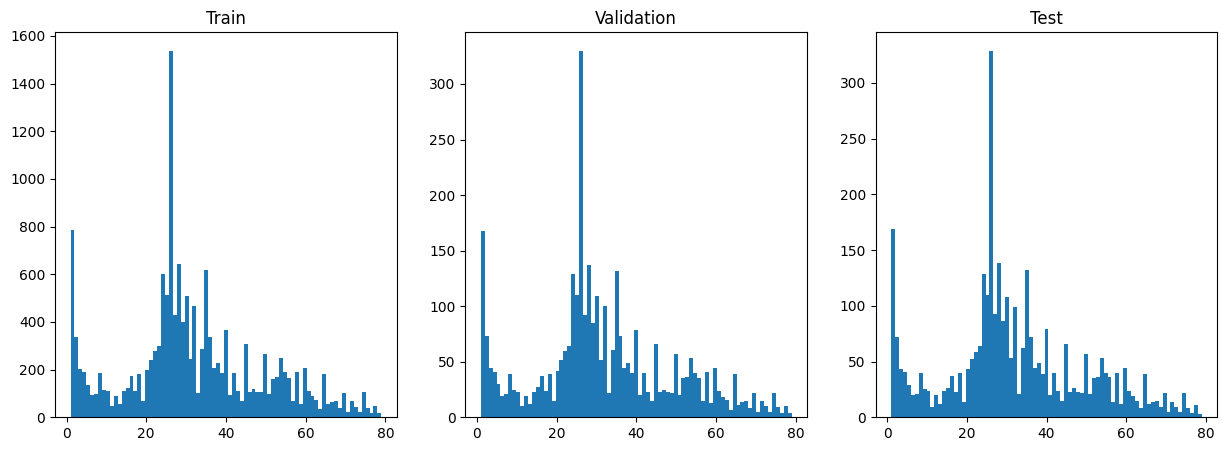

In [ ]:
# Split dataset to train, validation and test
df_train, temp = train_test_split(data_df, test_size=0.3, stratify=data_df.age, random_state=42)
df_test, df_valid = train_test_split(temp, test_size=0.5, stratify=temp.age, random_state=42)

# checking distributions of the training, validation, and test sets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

#save as csv
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

In [ ]:
# Define transformations for train and test sets

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Define custom dataset
class UTKDataset(Dataset):

    def __init__(self, root_dir, csv_file, transform=None):
      self.root_dir = root_dir
      self.csv_file = csv_file
      self.transform = transform
      self.data = pd.read_csv(csv_file)
      self.gender_dict = {'Male': 0, 'Female': 1}
      self.ethnicity_dict = {"White":0,"Black":1,"Asian":2,"Indian":3,"Others":4}

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx, :]

      img_name = sample.image_name
      img = Image.open(os.path.join(self.root_dir, img_name))
      img = self.transform(img)

      age = torch.tensor([sample.age], dtype=torch.float32)
      gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
      ethnicity = torch.tensor(self.ethnicity_dict[sample.ethnicity], dtype=torch.int32)

      return img, age#, gender, ethnicity

In [ ]:
# define objects of custom dataset for train, valid and test set
dataset_dir = '/content/utkcropped'

train_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/train_set.csv', transform=train_transform)
valid_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/valid_set.csv', transform=test_transform)
test_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/test_set.csv', transform=test_transform)

In [ ]:
train_set[5]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

In [ ]:
train_iter = iter(train_loader)
train_iter

# Model Configuration

In [ ]:
class AgeEstimationModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

  def forward(self, x):
    y = self.model(x)
    return y

In [ ]:
model = AgeEstimationModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
loss_fn = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)
metric = tm.MeanAbsoluteError().to(device)

# Train

## Train and Evaluate Functions

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [ ]:
train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=1)

Epoch 1:   0%|          | 0/126 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1: 100%|██████████| 126/126 [02:07<00:00,  1.02s/batch, loss=11, metric=11]


(AgeEstimationModel(
   (model): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downsample

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

In [ ]:
evaluate(model, valid_loader, loss_fn, metric)

(8.565961738398727, 8.565962791442871)

## Train Process and Tunning

### Finding Hyper-parameters

- Calculating the loss for untrained model using a few batches

In [ ]:
for iter_num in range(5):

  model = AgeEstimationModel().to(device)


  inputs, targets = next(iter(train_loader))
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

  print(loss)

tensor(33.4501, device='cuda:0')
tensor(34.1809, device='cuda:0')
tensor(31.6923, device='cuda:0')
tensor(34.4293, device='cuda:0')
tensor(31.2275, device='cuda:0')


- Train and try to overfit the model on a small subset of the dataset.

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = AgeEstimationModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 29: 100%|██████████| 50/50 [00:08<00:00,  5.89batch/s, loss=4.37, metric=4.37]


-  Train the model for a limited number of epochs, experimenting with various learning rates to find best value

In [ ]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')

  model = AgeEstimationModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=0.1


Epoch 2: 100%|██████████| 126/126 [02:13<00:00,  1.06s/batch, loss=8.36, metric=8.36]



LR=0.01


Epoch 2: 100%|██████████| 126/126 [02:07<00:00,  1.01s/batch, loss=6.16, metric=6.16]



LR=0.001


Epoch 2: 100%|██████████| 126/126 [02:07<00:00,  1.01s/batch, loss=6.11, metric=6.11]



LR=0.0001


Epoch 2:  25%|██▌       | 32/126 [00:31<01:31,  1.03batch/s, loss=16.9, metric=16.9]


KeyboardInterrupt: 

- Creat a small grid search to find exact value of lr and weight decay

In [ ]:
num_epochs = 3

for lr in [0.005, 0.003, 0.001]:
  for wd in [1e-4, 1e-5]:
    print(f'LR={lr}, WD={wd}')

    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=0.005, WD=0.0001


Epoch 2: 100%|██████████| 126/126 [02:01<00:00,  1.03batch/s, loss=6.14, metric=6.14]



LR=0.005, WD=1e-05


Epoch 2: 100%|██████████| 126/126 [02:02<00:00,  1.03batch/s, loss=6.18, metric=6.18]



LR=0.003, WD=0.0001


Epoch 2: 100%|██████████| 126/126 [02:02<00:00,  1.03batch/s, loss=6.67, metric=6.67]



LR=0.003, WD=1e-05


Epoch 2: 100%|██████████| 126/126 [02:02<00:00,  1.03batch/s, loss=6.68, metric=6.68]



LR=0.001, WD=0.0001


Epoch 2: 100%|██████████| 126/126 [02:04<00:00,  1.01batch/s, loss=10.8, metric=10.8]



LR=0.001, WD=1e-05


Epoch 2: 100%|██████████| 126/126 [02:08<00:00,  1.02s/batch, loss=10.5, metric=10.5]

- Train model for more epochs using the best hyperparameters

In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
lr = 0.005
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    shutil.copyfile("model.pt", "/content/drive/MyDrive/AgeEstimater/bestModel.pt")
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 126/126 [02:04<00:00,  1.01batch/s, loss=6.13, metric=6.13]


Valid: Loss = 5.919, MAE = 5.919



Epoch 1: 100%|██████████| 126/126 [02:03<00:00,  1.02batch/s, loss=5.57, metric=5.57]


Valid: Loss = 5.54, MAE = 5.54



Epoch 2: 100%|██████████| 126/126 [02:02<00:00,  1.03batch/s, loss=5.24, metric=5.24]


Valid: Loss = 5.783, MAE = 5.783



Epoch 3: 100%|██████████| 126/126 [02:03<00:00,  1.02batch/s, loss=5.02, metric=5.02]


Valid: Loss = 5.401, MAE = 5.401



Epoch 4: 100%|██████████| 126/126 [02:07<00:00,  1.01s/batch, loss=4.7, metric=4.7]


Model Saved!
Valid: Loss = 5.102, MAE = 5.102



Epoch 5: 100%|██████████| 126/126 [02:05<00:00,  1.00batch/s, loss=4.55, metric=4.55]


Model Saved!
Valid: Loss = 4.793, MAE = 4.793



Epoch 6: 100%|██████████| 126/126 [02:04<00:00,  1.01batch/s, loss=4.32, metric=4.32]


Valid: Loss = 5.157, MAE = 5.157



Epoch 7: 100%|██████████| 126/126 [02:02<00:00,  1.03batch/s, loss=4.26, metric=4.26]


Model Saved!
Valid: Loss = 4.769, MAE = 4.769



Epoch 8: 100%|██████████| 126/126 [02:08<00:00,  1.02s/batch, loss=4.16, metric=4.16]


Valid: Loss = 4.772, MAE = 4.772



Epoch 9: 100%|██████████| 126/126 [02:18<00:00,  1.10s/batch, loss=4, metric=4]


Model Saved!
Valid: Loss = 4.758, MAE = 4.758



### Main Train Loop

In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
lr = 0.001
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    shutil.copyfile("model.pt", "/content/drive/MyDrive/AgeEstimater/bestModel.pt")
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

### Plot Learning Curve

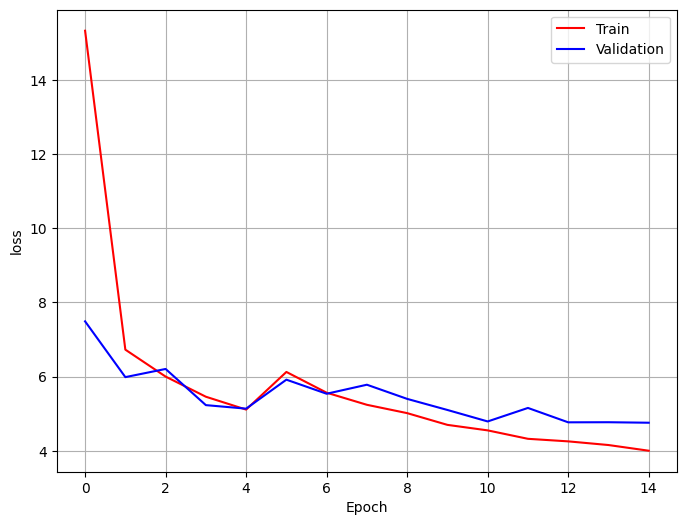

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# Test

In [ ]:
!cp /content/drive/MyDrive/AgeEstimater/bestModel.pt /content/

In [ ]:
model_path = '/content/bestModel.pt'
model = torch.load(model_path)
model.eval()

AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
_, metric_train = evaluate(model, train_loader, loss_fn, metric)
_, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
_, metric_test = evaluate(model, test_loader, loss_fn, metric)

metric_train, metric_valid, metric_test

(3.725048542022705, 4.758342266082764, 4.872828006744385)

# Inference

In [ ]:
!cp /content/drive/MyDrive/AgeEstimater/bestModel.pt /content/

In [ ]:
model_path = '/content/bestModel.pt'
model = torch.load(model_path)
model.eval()

AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
!pip install face-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=67275b07a040b151bd9412f47db64cea0efebe46de7e9bebbd2c46528b0e0192
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import face_recognition

In [ ]:
def inference(image_path, transform, model, face_detection=False):
  if face_detection:
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_crop = img[top:bottom, left:right]
    img_crop = Image.fromarray(img_crop)
  else:
    img_crop = Image.open(image_path).convert('RGB')

  img_tensor = transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds = model(img_tensor.to(device)).item()

  return preds, img_crop

60.26


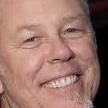

In [ ]:
# Test custom image

preds, img = inference("/content/drive/MyDrive/AgeEstimater/JamesHetfield.jpg",
          test_transform, model, face_detection=True)

print(f'{preds:.2f}')
img

Real: 27, Predicted: 24.97


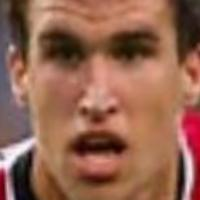

In [ ]:
# Test random img from test csv

folder_image_path = '/content/utkcropped'
csv_file_path = '/content/test_set.csv'
df = pd.read_csv(csv_file_path)

rand_idx = random.randint(0, df.shape[0])
test_image_name = df.iloc[rand_idx].image_name
test_image_path = os.path.join(folder_image_path, test_image_name)
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image

# Experiments


In [ ]:
!cp /content/drive/MyDrive/AgeEstimater/bestModel.pt /content/

In [ ]:
model_path = '/content/bestModel.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
all_outputs, all_targets = [], []

for inputs, targets in test_loader:
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.inference_mode():
    outputs = model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

In [ ]:
all_outputs = torch.vstack(all_outputs).squeeze()
all_targets = torch.vstack(all_targets).squeeze()
all_outputs.shape, all_targets.shape

(torch.Size([3455]), torch.Size([3455]))

In [ ]:
mae = F.l1_loss(all_outputs, all_targets, reduction='none')
mae.shape

torch.Size([3455])

In [ ]:
df_test = pd.read_csv('/content/test_set.csv')

df_test['preds'] = all_outputs.cpu()
df_test['maes'] = mae.cpu()
df_test.to_csv('/content/test_outputs.csv')
df_test.head()

,image_name,age,ethnicity,gender,preds,maes
0,28_1_2_20170116162424590.jpg.chip.jpg,28,Asian,Female,23.782841,4.217159
1,34_1_1_20170116164431637.jpg.chip.jpg,34,Black,Female,25.143991,8.856009
2,4_1_2_20161219153328036.jpg.chip.jpg,4,Asian,Female,4.823397,0.823397
3,21_1_2_20170116175142157.jpg.chip.jpg,21,Asian,Female,25.978909,4.978909
4,30_0_1_20170113141818644.jpg.chip.jpg,30,Black,Male,32.316040,2.316040


In [ ]:
df_test.groupby('age')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,169.0,1.062539,3.476042,0.000267,0.185524,0.392158,0.876198,34.142738
2,72.0,0.736954,0.740085,0.026151,0.289881,0.555043,0.788126,4.381279
3,43.0,1.743244,2.509956,0.013811,0.622910,1.086515,1.484711,13.710539
4,41.0,2.691671,4.813756,0.128346,0.866838,1.715883,2.474851,31.025208
5,29.0,2.557053,2.229938,0.010706,0.784526,1.605931,3.902460,7.649935
...,...,...,...,...,...,...,...,...
75,22.0,8.878423,5.769646,0.803017,5.392166,8.017090,10.664526,22.795578
76,8.0,13.228819,11.015420,6.666840,7.441698,10.408936,11.767477,39.934254
77,4.0,16.770634,3.861565,13.306606,13.709390,16.220619,19.281862,21.334686


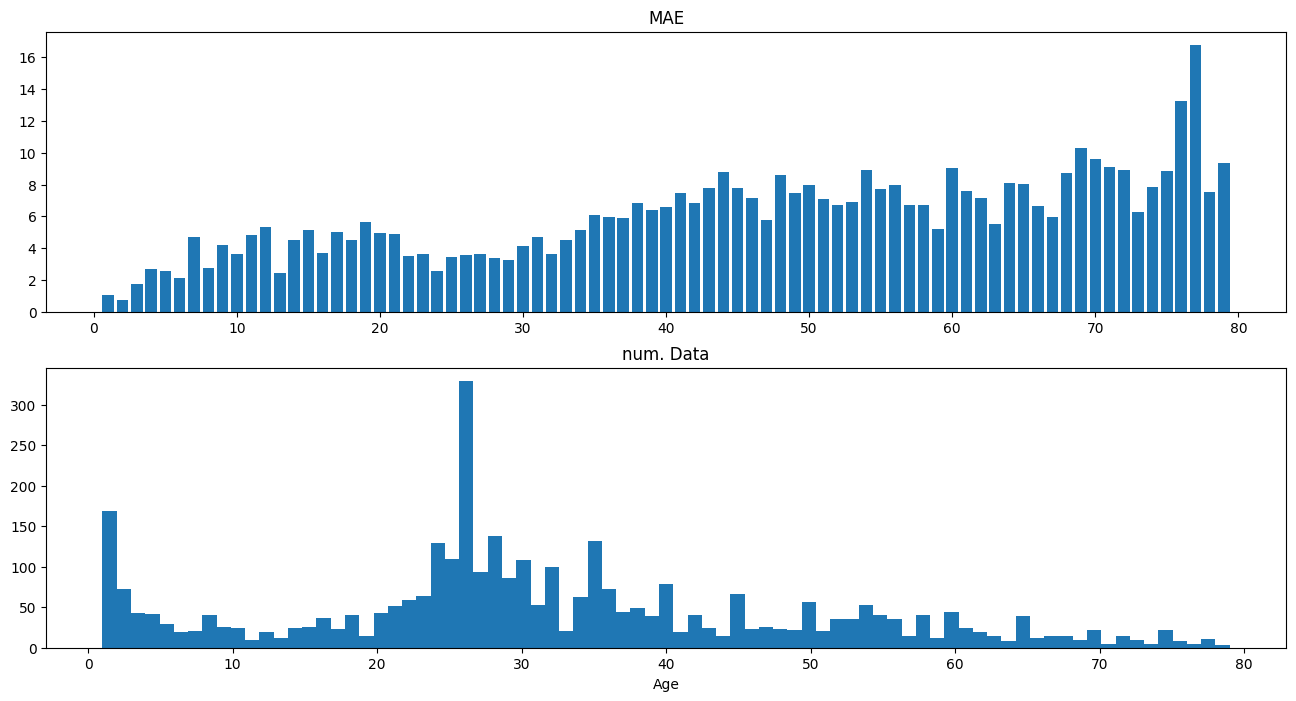

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])
plt.title("MAE")

plt.subplot(2, 1, 2)
plt.hist(df_test.age, bins=len(df_test.age.unique()));
plt.title("num. Data")
plt.xlabel("Age");

In [ ]:
df_test.groupby('gender')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1602.0,4.677388,4.854795,0.002247,1.222074,3.108445,6.654924,35.261421
Male,1853.0,5.041795,4.913811,0.000267,1.454346,3.706339,7.066822,39.934254


In [ ]:
df_test.groupby('ethnicity')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
Asian,509.0,3.640575,4.205245,0.004955,0.750677,2.114506,4.985825,28.537298
Black,665.0,5.452895,5.138116,0.005480,1.803827,4.025991,7.329556,39.934254
Indian,566.0,4.662964,4.553069,0.006119,1.267466,3.290549,6.906024,32.909676
Others,256.0,3.694193,3.450022,0.002960,0.947823,2.660550,5.357527,19.134874
White,1459.0,5.326554,5.213346,0.000267,1.505772,3.815163,7.612843,35.261421


In [ ]:
ranges = np.arange(df.age.min()-1, df.age.max()+1, 5)
df_test['age_period'] = pd.cut(df.age, bins=ranges)
df_test.head()

,image_name,age,ethnicity,gender,preds,maes,age_period
0,28_1_2_20170116162424590.jpg.chip.jpg,28,Asian,Female,23.782841,4.217159,"(25, 30]"
1,34_1_1_20170116164431637.jpg.chip.jpg,34,Black,Female,25.143991,8.856009,"(30, 35]"
2,4_1_2_20161219153328036.jpg.chip.jpg,4,Asian,Female,4.823397,0.823397,"(0, 5]"
3,21_1_2_20170116175142157.jpg.chip.jpg,21,Asian,Female,25.978909,4.978909,"(20, 25]"
4,30_0_1_20170113141818644.jpg.chip.jpg,30,Black,Male,32.316040,2.316040,"(25, 30]"


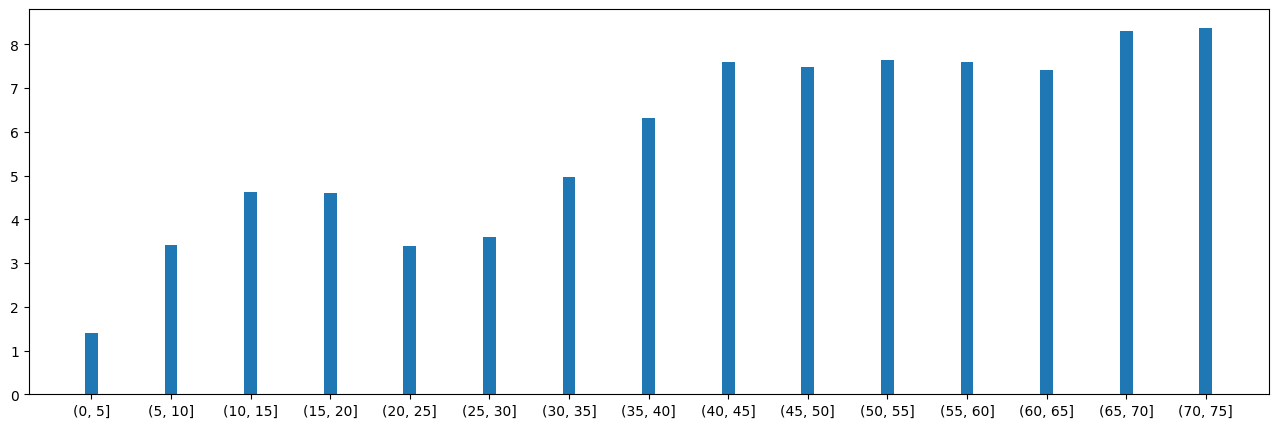

In [ ]:
plt.figure(figsize=(16, 5))

plt.bar(ranges[:-1],
        df_test.groupby('age_period')['maes'].describe()['mean']);
plt.xticks(ranges[:-1], df_test.groupby('age_period')['maes'].describe().index);
